# Assignment 4 - Solving a Finite Element System
### Student Number 19008330

Final Grade: 25/30 (83.3%)


## Part 0: Preamble

In [ ]:
!pip install pyamg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import numpy as np
import numba
from scipy.linalg import solve_triangular, lu
import scipy,scipy.sparse, scipy.sparse.linalg
from scipy.sparse.linalg import spsolve, LinearOperator, cg, gmres, bicgstab, qmr, spilu, splu
from scipy.sparse import csr_matrix,coo_matrix,csc_matrix,linalg
from timeit import timeit
import pyamg
from pyamg import smoothed_aggregation_solver as smooth
from pyamg import ruge_stuben_solver as ruge
from numpy.lib import stride_tricks
from numpy.lib.stride_tricks import as_strided

In [ ]:
import numpy as np

# A and b for N=2
A_2 = np.array([
    [-0.11111111111111116],
])
b_2 = np.array([0.2699980311833446])

# A and b for N=3
A_3 = np.array([
    [1.4320987654320987, -0.6419753086419753, -0.6419753086419753, -0.4104938271604938],
    [-0.6419753086419753, 1.4320987654320987, -0.4104938271604938, -0.6419753086419753],
    [-0.6419753086419753, -0.4104938271604938, 1.4320987654320987, -0.6419753086419753],
    [-0.4104938271604938, -0.6419753086419753, -0.6419753086419753, 1.4320987654320987],
])
b_3 = np.array([1.7251323007221917, 0.15334285313223067, -0.34843455260733003, -1.0558651156722307])

# A and b for N=4
A_4 = np.array([
    [1.972222222222222, -0.5069444444444444, 0.0, -0.5069444444444444,
     -0.3767361111111111, 0.0, 0.0, 0.0, 0.0],
    [-0.5069444444444444, 1.972222222222222, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444,
     -0.3767361111111111, 0.0, 0.0, 0.0],
    [0.0, -0.5069444444444444, 1.972222222222222, 0.0, -0.3767361111111111, 
     -0.5069444444444444, 0.0, 0.0, 0.0],
    [-0.5069444444444444, -0.3767361111111111, 0.0, 1.972222222222222, 
     -0.5069444444444444, 0.0, -0.5069444444444444, -0.3767361111111111, 0.0],
    [-0.3767361111111111, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, 
     1.972222222222222, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, -0.3767361111111111],
    [0.0, -0.3767361111111111, -0.5069444444444444, 0.0, -0.5069444444444444, 
     1.972222222222222, 0.0, -0.3767361111111111, -0.5069444444444444],
    [0.0, 0.0, 0.0, -0.5069444444444444, -0.3767361111111111, 0.0, 
     1.972222222222222, -0.5069444444444444, 0.0],
    [0.0, 0.0, 0.0, -0.3767361111111111, -0.5069444444444444, -0.3767361111111111, 
     -0.5069444444444444, 1.972222222222222, -0.5069444444444444],
    [0.0, 0.0, 0.0, 0.0, -0.3767361111111111, -0.5069444444444444, 0.0, -0.5069444444444444, 1.972222222222222],
])
b_4 = np.array([1.4904895819530766, 1.055600747809247, 0.07847904705126368, 0.8311407883427149, 0.0, 
                -0.8765020708205272, -0.6433980946818605, -0.7466392365712349, -0.538021498324083])

A_5 = np.array([
    [2.222222222222222, -0.4444444444444444, 0.0, 0.0, -0.4444444444444444, -0.3611111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [-0.4444444444444444, 2.222222222222222, -0.4444444444444444, 0.0, -0.3611111111111111, -0.4444444444444444, -0.3611111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, -0.4444444444444444, 2.222222222222222, -0.4444444444444444, 0.0, -0.3611111111111111, -0.4444444444444444, -0.3611111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, -0.4444444444444444, 2.222222222222222, 0.0, 0.0, -0.3611111111111111, -0.4444444444444444, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [-0.4444444444444444, -0.3611111111111111, 0.0, 0.0, 2.222222222222222, -0.4444444444444444, 0.0, 0.0, -0.4444444444444444, -0.3611111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [-0.3611111111111111, -0.4444444444444444, -0.3611111111111111, 0.0, -0.4444444444444444, 2.222222222222222, -0.4444444444444444, 0.0, -0.3611111111111111, -0.4444444444444444, -0.3611111111111111, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, -0.3611111111111111, -0.4444444444444444, -0.3611111111111111, 0.0, -0.4444444444444444, 2.222222222222222, -0.4444444444444444, 0.0, -0.3611111111111111, -0.4444444444444444, -0.3611111111111111, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, -0.3611111111111111, -0.4444444444444444, 0.0, 0.0, -0.4444444444444444, 2.222222222222222, 0.0, 0.0, -0.3611111111111111, -0.4444444444444444, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, -0.4444444444444444, -0.3611111111111111, 0.0, 0.0, 2.222222222222222, -0.4444444444444444, 0.0, 0.0, -0.4444444444444444, -0.3611111111111111, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, -0.3611111111111111, -0.4444444444444444, -0.3611111111111111, 0.0, -0.4444444444444444, 2.222222222222222, -0.4444444444444444, 0.0, -0.3611111111111111, -0.4444444444444444, -0.3611111111111111, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, -0.3611111111111111, -0.4444444444444444, -0.3611111111111111, 0.0, -0.4444444444444444, 2.222222222222222, -0.4444444444444444, 0.0, -0.3611111111111111, -0.4444444444444444, -0.3611111111111111],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3611111111111111, -0.4444444444444444, 0.0, 0.0, -0.4444444444444444, 2.222222222222222, 0.0, 0.0, -0.3611111111111111, -0.4444444444444444],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.4444444444444444, -0.3611111111111111, 0.0, 0.0, 2.222222222222222, -0.4444444444444444, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3611111111111111, -0.4444444444444444, -0.3611111111111111, 0.0, -0.4444444444444444, 2.222222222222222, -0.4444444444444444, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3611111111111111, -0.4444444444444444, -0.3611111111111111, 0.0, -0.4444444444444444, 2.222222222222222, -0.4444444444444444],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3611111111111111, -0.4444444444444444, 0.0, 0.0, -0.4444444444444444, 2.222222222222222],
])

b_5 = np.array([1.2673039440507343, 0.9698054647507671, 1.0133080988552785, 0.07206335813040798, 0.9472174493756345, 0.0, 0.0, -0.9416429716282946, 0.6400834406610956, 0.0, 0.0, -0.7322882523543968, -0.8159823324771336, -0.9192523853093425, -0.48342793699793585, -0.19471066818706848])

## Part 1: Sparse Matrix and Vector Construction taking only an input $N$.


In [ ]:
def fems(N): #Finite element method solution
  
  # Key Constants

  k = 5
  h = 1/N
  n = N-1
  n2 = n**2
  
  # Sparse Matrix Construction: coo_matrix for easy data entry
  d1 = (1/9)*(24-4*(h*k)**2)
  vh = (1/9)*(-3-(h*k)**2)
  d2 = (1/36)*(-12-(h*k)**2)

  rows,cols,data = [],[],[]
 
  for i in range(n2):
    for j in range(n2):
      # pointers for when rows and columns reach boundary

      i1 = int(i/n)
      j1 = int(j/n)

      if i == j: 
        # The main diagonal component
        rows += [i]
        cols += [j]
        data += [(1/9)*(24-4*(h*k)**2)]

      elif (abs(j-i) == 1 and i1 == j1) or (abs(j-i) == abs(n) and abs(i1-j1) == 1):
        # Horizontally and vertically adjacent points
        rows += [i]
        cols += [j]
        data += [(1/9)*(-3-(h*k)**2)]

      elif (abs(j-i) == N and abs(i1-j1) == 1) or (abs(j-i) == abs(N-2) and abs(i1-j1) == 1):
        # Diagonally adjacent points
        rows += [i]
        cols += [j]
        data += [(1/36)*(-12-(h*k)**2)]
      else:
        rows += [i]
        cols += [j]
        data += [0]
   
  rows = np.array(rows,dtype = np.float64)
  cols = np.array(cols,dtype = np.float64)
  data = np.array(data,dtype = np.float64)
  A_shape = n2,n2
  A = coo_matrix((data,(rows,cols)), shape = A_shape)

  ### Vector Construction ###

  b = np.zeros(shape = n2, dtype = np.float64)
  da = (1/36)*(12 + (h*k)**2) # Diagonally Adjacent 
  va = ha = (1/9)*(3 + (h*k)**2) # Vertically or Horizontally Adjacent

  def g(x,y): # Nested Function

    '''Since all the points p_j required for the vector are along
    the boundary, it's perfectly acceptable to write g(x,y) in this form.
    No need for if and elif statements.'''
    return np.sin(3*x + 4*y)
    

  # Bottom Left and Top Right Points in p_j grid
  
  b[0] += da*(g(0,0) + g(2*h,0) + g(0,2*h)) + va*(g(h,0) + g(0,h))
  b[-1] += da*(g(1,1) + g(1-2*h,1) + g(1,1-2*h)) + va*(g(1-h,1) + g(1,1-h))
  
  # Top Left and Bottom Right Points in p_j grid
  b[n-1] += da*(g(1,0) + g(1,2*h) + g(1-(2*h),0)) + va*(g(1-h,0) + g(1,h))
  b[-n] += da*(g(0,1) + g(2*h,1) + g(0,1-2*h)) + va*(g(h,1) + g(0,1-h))

  b1 = []
  b2 = []
  b3 = []
  b4 = []
  
  for j in range(1,N-2): # N-2 retrieves all non-zero values in vector
    
    # Ensuring index follows b[j] requirements   
    cj = h*(j+1)
    b1 += [da*(g(0,cj + h) + g(0,cj - h)) + va*(g(0,cj))]
    b2 += [da*(g(1,cj + h) + g(1,cj - h)) + va*(g(1,cj))]
    b3 += [da*(g(cj + h,0) + g(cj - h,0)) + va*(g(cj,0))]
    b4 += [da*(g(cj + h,1) + g(cj - h,1)) + va*(g(cj,1))]
  
  b4.reverse() #Entries for the last points need to be reversed

  for j in range(1,N-2):

    b[n*j] += b1[j-1] # Edge Points 1
    b[n*(j+1)-1] += b2[j-1] # Edge Points 2
    b[j] += b3[j-1] # First Points
    b[-1-j] += b4[j-1] # Last Points
  

  return A.tocsr(),b

In [ ]:
A3,b3 = fems(3)
A4,b4 = fems(4)
A5,b5 = fems(5)

def dense(A):
  return A.todense()

#Ensuring Matrix is correct

assert np.allclose(dense(A3),A_3)
assert np.allclose(dense(A4),A_4)
assert np.allclose(dense(A5),A_5)

# Ensuring Vector is correct

assert np.allclose(b3,b_3)
assert np.allclose(b4,b_4)
assert np.allclose(b5,b_5)

The following functions will return the required matrices and vectors from the assignment sheet, showing the ``fems`` function provides a finite element method solution which is correct and matches the examples provided in the assignment sheet.

## Part 2: Solving the matrix-vector problem for $N = 4,8, 16$ with associated 3D plots.


In [ ]:
def grid_outline(N):
  
  # (N+1) points along x,y direction for grid as required
  grid = np.zeros(shape = (N+1,N+1), dtype = np.float64)
  i = np.linspace(0,1,N+1)
  '''
  Using the conditions for g(x,y) to retrieve points along the boundary
  '''
  grid[0,:] = np.sin(3*i)
  grid[:,0] = np.sin(4*i)
  grid[N,:] = np.sin(3+4*i)
  grid[:,N] = np.sin(4*i+3)

  return grid  

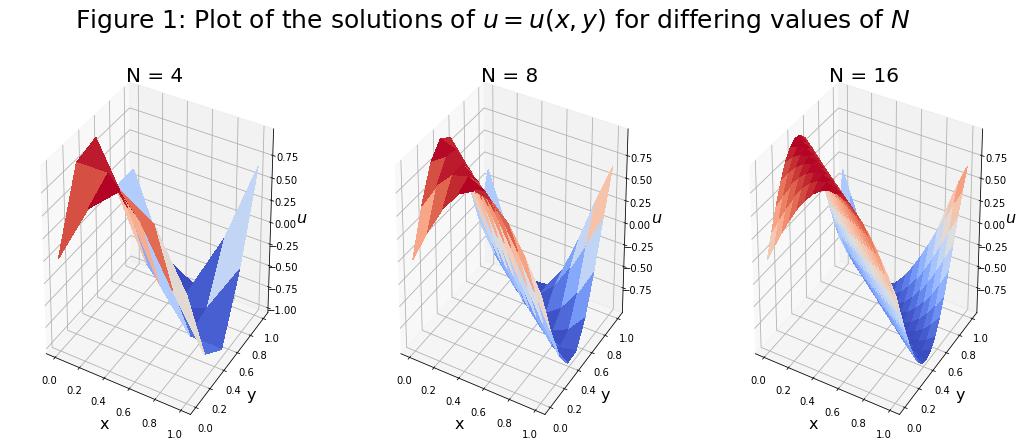

In [ ]:
%matplotlib inline
N = [4,8,16]
fig = plt.figure(figsize = (18,7))
k = 1 # Counter to produce row of plots
for n in N:

  # Solving for Interior Points and reshaping
  A,b = fems(n)
  x = spsolve(A.tocsc(),b)
  u = grid_outline(n)
  u[1:n,1:n] += x.reshape(n-1,n-1)
  
  #Adding interior points to the grid, obtaining full solution
  
  ax = fig.add_subplot(1,3,k, projection = '3d')
  ticks = np.linspace(0,1,n+1)
  X,Y  = np.meshgrid(ticks,ticks)
  surf = ax.plot_surface(X,Y,u, antialiased=False, cmap=cm.coolwarm)
  ax.set_xlabel("x",fontsize=16)
  ax.set_ylabel("y",fontsize=16)
  ax.set_zlabel("$u$",fontsize=16)
  ax.set_title("N = {}".format(n), size = 20)
  k += 1

plt.suptitle('Figure 1: Plot of the solutions of $u = u(x,y)$ for differing values of $N$',size = 25)
plt.show()

Figure 1 returns a 3D wave solution for various squares on a grid from $\Omega = [0,1]^{2}$. As the number of squares on the grid increases and subsequently the grid space decreases, the solution $u(x,y)$ begins to look like a more smooth and robust 3D wave solution. Showing that matrix-vector products for larger $N$ result in greater apprximate solutions.

## Part 3 Comparing Solvers and Preconditioning

I've chosen to compare 4 iterative solvers:

- Generalised Minimal Residual Method (GMRES)
- Conjugate Gradient Method (CG)
- Biconjugate Gradient Stabilized Iteration Method (BICGSTAB)
- Quasi-Minimal Residual Method (QMR)

with one direct solver being the ``spsolve`` from scipy.sparse.

Determining the optimum solver and preconditioner



- Runtime of the solver.
- Number of iterations required by each solver. 
- The size of the residuals after each iteration.

Once the two best solvers have been determined. I will apply three preconditioners and measure the same three factors stated above. These preconditioners are:





In [ ]:
def residuals(solver,N):
  
  A,b = fems(N)
  res = []
  if solver == cg: # Iterative Solver 1

    cg_callback = lambda x: res.append(np.linalg.norm(b - A @ x)/np.linalg.norm(b))
    sol, _ = cg(A,b,tol = 1e-14, callback = cg_callback, maxiter = 1000)

  if solver == gmres: # Iterative Solver 2
    
    gmres_callback = lambda x: res.append(x)
    sol, _ = gmres(A,b,tol = 1e-14,callback = gmres_callback, maxiter = 1000)
  
  if solver == bicgstab: # Iterative Solver 3
    bicgstab_callback = lambda x: res.append(np.linalg.norm(b - A @ x)/np.linalg.norm(b))
    sol,_ = bicgstab(A,b, tol = 1e-14, callback = bicgstab_callback, maxiter = 1000)
  
  if solver == qmr: # Iterative Solver 4
    qmr_callback = lambda x: res.append(np.linalg.norm(b - A @ x)/np.linalg.norm(b))
    sol,_ = qmr(A,b, tol = 1e-14, callback = qmr_callback, maxiter = 1000)
 
  if solver == spsolve: # Direct Solver 1
    # Sparse Efficiency dictates that csc_matrix is required
    A,b = fems(n)
    x = spsolve(A,b)
    res = np.linalg.norm(b - A.tocsc() @ x)/np.linalg.norm(b)
  
  return res #,x



Note: I tried to create a function which returns the finite element solution using each solver but this got very frustrating and I decided to abandon it.

Text(0.5, 0.98, 'Figure 2a: Relative Residual size after each iteration step for differing iterative solvers and values of $N$')

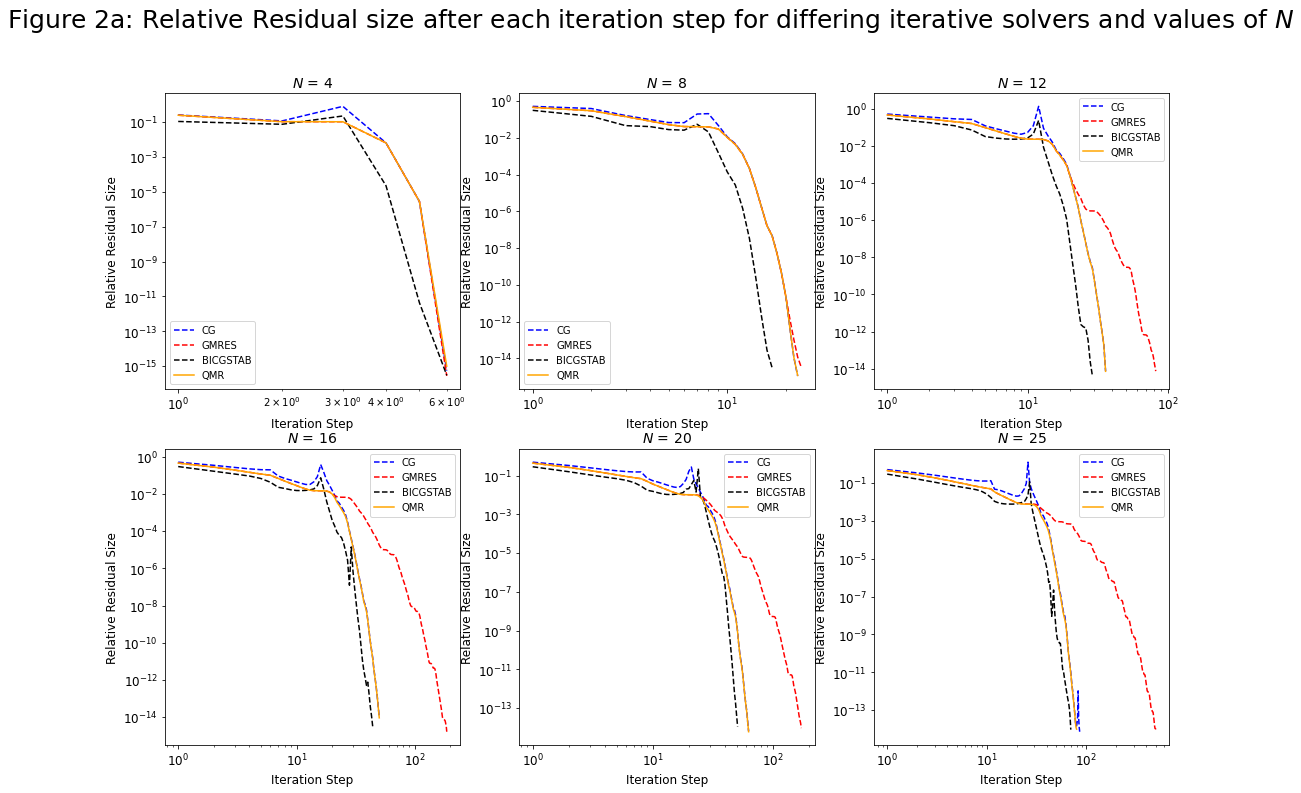

In [ ]:
N = np.array([4,8,12,16,20,25]) # These are what I interpret as small to medium values of N.
fig = plt.figure(figsize = (18,12))
k = 1

min_cg = []
min_gmres = []
min_bicgstab = []
min_qmr = []
dir = []

for n in N:

  # Obtaining Minimal Residuals to Compare to Direct Solver

  min_cg.append(np.min(residuals(cg,n)))
  min_gmres.append(np.min(residuals(gmres,n)))
  min_bicgstab.append(np.min(residuals(qmr,n)))
  min_qmr.append(np.min(residuals(bicgstab,n)))
  dir.append(residuals(spsolve,n))

  # Plotting for Relative Residuals

  ax = fig.add_subplot(2,3,k)
  ax.set_xlabel('Iteration Step', size = 12)
  ax.set_ylabel('Relative Residual Size', size = 12)
  ax.plot(1 + np.arange(len(residuals(cg,n))), residuals(cg,n), 'b--')
  ax.plot(1 + np.arange(len(residuals(gmres,n))), residuals(gmres,n), 'r--')
  ax.plot(1 + np.arange(len(residuals(bicgstab,n))), residuals(bicgstab,n), 'k--')
  ax.plot(1 + np.arange(len(residuals(qmr,n))), residuals(qmr,n), 'orange')
  ax.set_title('$N$ = {}'.format(n), size = 14)
  ax.legend(["CG", "GMRES","BICGSTAB", "QMR"]) 
  ax.set_xscale("log")
  ax.set_yscale("log")
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)
  k += 1

plt.suptitle("Figure 2a: Relative Residual size after each iteration step for differing iterative solvers and values of $N$",size = 25)


Text(0.5, 1.0, 'Figure 2b: Average Minimum Residual of Sparse Solver')

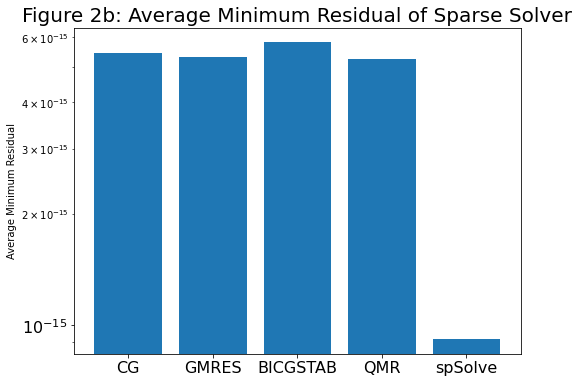

In [ ]:
amr_cg = np.average(min_cg)
amr_gmres = np.average(min_gmres)
amr_bicgstab = np.average(min_bicgstab)
amr_qmr = np.average(min_qmr)
amr_dir = np.average(dir)
fig = plt.figure(figsize = (8,6))
res_comp = [amr_cg,amr_gmres,amr_bicgstab,amr_qmr,amr_dir]
obs = ['CG', 'GMRES','BICGSTAB','QMR','spSolve']
y_pos = np.arange(len(obs))
plt.bar(y_pos,res_comp)
plt.xticks(y_pos,obs, size = 14)
plt.yscale('log')
plt.ylabel("Average Minimum Residual")
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.title('Figure 2b: Average Minimum Residual of Sparse Solver', size = 20)

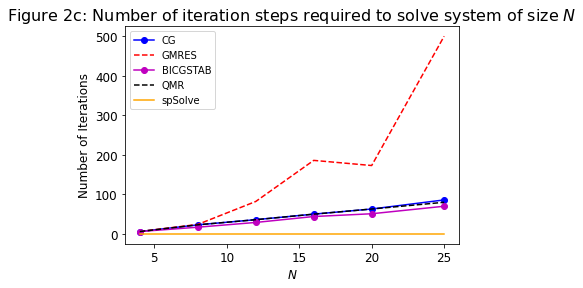

In [ ]:
N = np.array([4,8,12,16,20,25]) # These are what I interpret as small to medium values of N.

cg_iter = []
gmres_iter = []
bicgstab_iter = []
qmr_iter = []
spsolve_iter = []


for n in N:
  
  cg_iter.append(len(residuals(cg,n)))
  gmres_iter.append(len(residuals(gmres,n)))
  bicgstab_iter.append(len(residuals(bicgstab,n)))
  qmr_iter.append(len(residuals(qmr,n)))
  spsolve_iter.append(np.array([residuals(spsolve,n)]))

# Plotting Number of Iteration steps for each size Matrix in array

plt.xlabel('$N$', size = 12)
plt.ylabel('Number of Iterations', size = 12)
plt.plot(N, cg_iter, 'b-o')
plt.plot(N, gmres_iter, 'r--')
plt.plot(N, bicgstab_iter, 'm-o')
plt.plot(N, qmr_iter, 'k--')
plt.plot(N, spsolve_iter, 'orange')
plt.title('Figure 2c: Number of iteration steps required to solve system of size $N$', size = 16)
plt.legend(["CG", "GMRES","BICGSTAB", "QMR","spSolve"]) 
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

  


In [ ]:
def rt_cg(A,b):
  return cg(A,b, tol = 1e-6)

def rt_gmres(A,b):
  return gmres(A,b,tol = 1e-6)

def rt_bicgstab(A,b):
  return bicgstab(A,b,tol = 1e-6)

def rt_qmr(A,b):
  return qmr(A,b,tol = 1e-6)

def rt_spsolve(A,b):
  return spsolve(A,b)

def sparse_time(operator,runs,N):
  
  def op_time(operator,A,b,runs):
    assign = {'rt_gmres': rt_gmres,'rt_cg': rt_cg, 'rt_bicgstab': rt_bicgstab,
              'rt_qmr': rt_qmr,'rt_spsolve': rt_spsolve,'A': A ,'b':b}
    return timeit(lambda: operator(A,b), number = runs, globals = assign)
  
  output = []
  for n in N:
    A,b = fems(n)
    
    if runs <= 0:
      raise ValueError("Input needs to be a positive integer")
    if runs == 1:
      output.append(op_time(operator,A,b,runs))
    if runs > 1:
      output.append(op_time(operator,A,b,runs)/runs)
      
  return output

In [ ]:
N = np.arange(4,50,4)
v1 = sparse_time(rt_cg,15,N)
v2 = sparse_time(rt_gmres,15,N)
v3 = sparse_time(rt_bicgstab,15,N)
v4 = sparse_time(rt_qmr,15,N)
v5 = sparse_time(rt_spsolve,15,N)

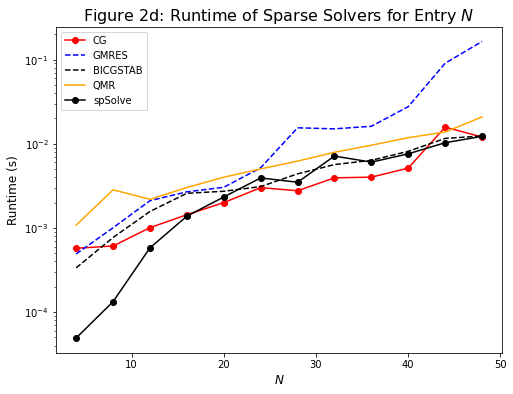

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(N,v1, "r-o")
plt.plot(N,v2,"b--")
plt.plot(N,v3,"k--")
plt.plot(N,v4,"orange")
plt.plot(N,v5,"k-o")
plt.xlabel("$N$", size = 12)
plt.ylabel("Runtime (s)", size = 12)
plt.title("Figure 2d: Runtime of Sparse Solvers for Entry $N$", size = 16)
plt.legend(["CG","GMRES","BICGSTAB","QMR","spSolve"])
plt.yscale("log")

From Figures 2a to 2d, I determine ``bicgstab`` and ``cg`` are the most effective iterative solvers due to having the least iterations required to determine the finite element (FEMS). Additionally, these solvers have the fastest runtime overall, particularly ``cg`` for larger matrices, and are straightforward to apply additional preconditioners to, in the aim of observing improvementss in the FEMS. The runtime of ``spsolve`` drastically increases more so than ``bicgstab`` for larger values of $N$. For very large matrices required later on, the runtime make ``spsolve`` less than optimal for solving the matrix vector problem.

As a result, I will utilise these solvers in combination  with four different preconditioners:

1. Partial (Incomplete) Super LU Decomposition (SPILU)
2. Super LU Decomposition (SPLU)
3. Smooth Algebraic Multigrid (Smooth)
4. Ruge-Stuben Algerbraic Multigrid (Ruge)

In [ ]:
def res_pc(N,solver,preconditioner): # Determining Residuals with pre-conditioning
    
    A,b = fems(N)
    A1 = A.tocsc()
    res = []
    
    if preconditioner == spilu: # Preconditioner 1: Partial/Incomplete LU decomposition
        
        # CSC_Matrix is the Required Sparse Forms
        pre_c = LinearOperator(matvec = spilu(A1, fill_factor = 20, drop_rule = 'dynamic').solve,
        shape = A1.shape, dtype = np.float64)
        
        callback_spilu = lambda x: res.append(np.linalg.norm(b - A1 @ x)/np.linalg.norm(b))      
        x, _ = solver(A1,b,tol = 1e-14, callback = callback_spilu, M = pre_c)
    
    if preconditioner == splu: # Preconditioner 2: Super LU decomposition
        pre_c = LinearOperator(matvec = splu(A1,permc_spec = 'NATURAL').solve,
        shape = A1.shape, dtype = np.float64)

        callback_superLU = lambda x: res.append(np.linalg.norm(b - A @ x)/np.linalg.norm(b))
        x, _ = solver(A1,b, tol = 1e-14,callback = callback_superLU, M = pre_c)

    if preconditioner == smooth: # Preconditioner 3: Smoothed Aggregation Solver
        
        # Sparse Efficieny Dictates CSR form of Matrix
        pre_c = smooth(A).aspreconditioner()
        callback_smooth = lambda x: res.append(np.linalg.norm(b - A @ x)/np.linalg.norm(b))
        x,_ = solver(A,b, tol= 1e-14, callback = callback_smooth, M = pre_c)
        
    if preconditioner == ruge: # Preconditioner 4: Ruge-Stuben Algebraic Multrigrid      
        
        pre_c = ruge(A).aspreconditioner()
        callback_ruge = lambda x: res.append(np.linalg.norm(b - A @ x)/np.linalg.norm(b))
        x,_ = solver(A,b, tol= 1e-14, callback = callback_ruge, M = pre_c)
        
    return res #, x



Text(0.5, 0.98, 'Figure 3a: Relative Residual size after each iteration step for differing values of $N$')

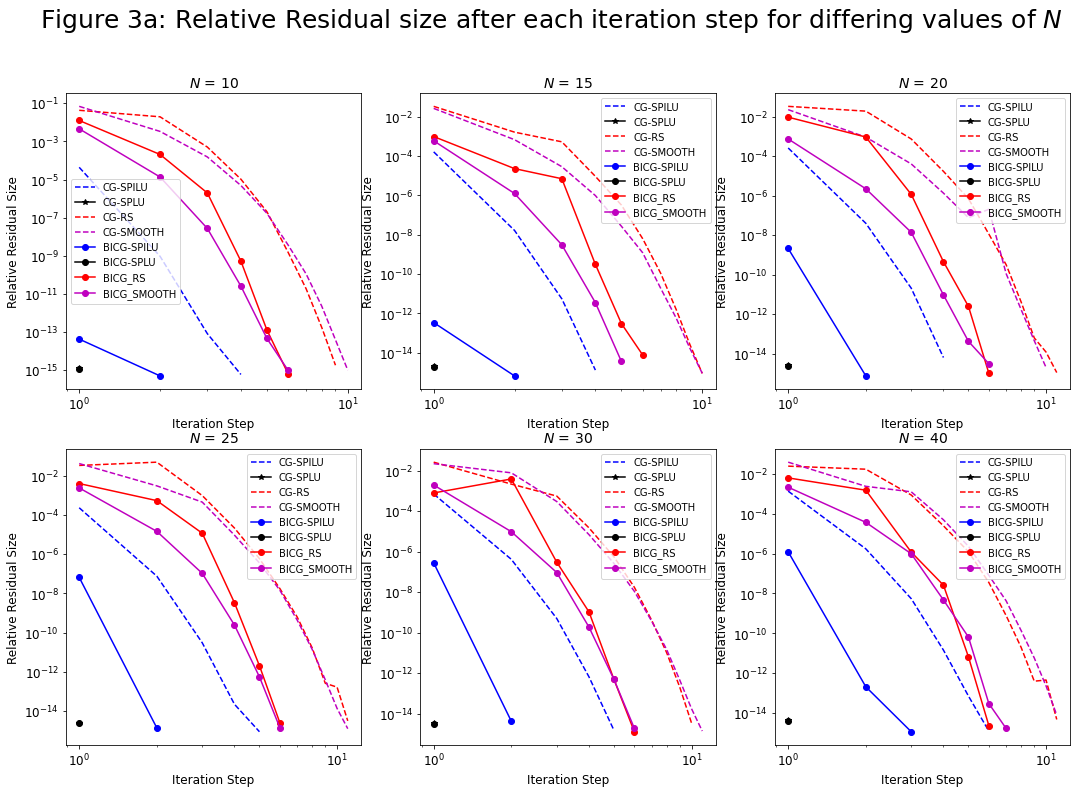

In [ ]:
N = np.array([10,15,20,25,30,40]) 
fig = plt.figure(figsize = (18,12))
k = 1

for n in N:
  ax = fig.add_subplot(2,3,k)
  ax.set_xlabel('Iteration Step', size = 12)
  ax.set_ylabel('Relative Residual Size', size = 12)
  ax.plot(1 + np.arange(len(res_pc(n,cg,spilu))), res_pc(n,cg,spilu), 'b--')
  ax.plot(1 + np.arange(len(res_pc(n,cg,splu))), res_pc(n,cg,splu), 'k-*')
  ax.plot(1 + np.arange(len(res_pc(n,cg,ruge))), res_pc(n,cg,ruge), 'r--')
  ax.plot(1 + np.arange(len(res_pc(n,cg,smooth))), res_pc(n,cg,smooth), 'm--')
  ax.plot(1 + np.arange(len(res_pc(n,bicgstab,spilu))), res_pc(n,bicgstab,spilu), 'b-o')
  ax.plot(1 + np.arange(len(res_pc(n,bicgstab,splu))), res_pc(n,bicgstab,splu), 'k-o')
  ax.plot(1 + np.arange(len(res_pc(n,bicgstab,ruge))), res_pc(n,bicgstab,ruge), 'r-o')
  ax.plot(1 + np.arange(len(res_pc(n,bicgstab,smooth))), res_pc(n,bicgstab,smooth), 'm-o')


  ax.set_title('$N$ = {}'.format(n), size = 14)
  ax.legend(["CG-SPILU", "CG-SPLU","CG-RS","CG-SMOOTH","BICG-SPILU","BICG-SPLU","BICG_RS","BICG_SMOOTH"]) #,"CG-SMOOTH", "BICGSTAB-SPILU", "BICGSTAB-RUBEN","BICGSTAB-SMOOTH"]) 
  ax.set_xscale("log")
  ax.set_yscale("log")
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)
  k += 1

plt.suptitle("Figure 3a: Relative Residual size after each iteration step for differing values of $N$",size = 25)
    

Quick Note: The Point for "CG-SPLU" is in te same position as that for "BICG-SPLU", it just doesn't show as the latter point overides the former on ``plt.plot``. However, I can assure that the point is there.

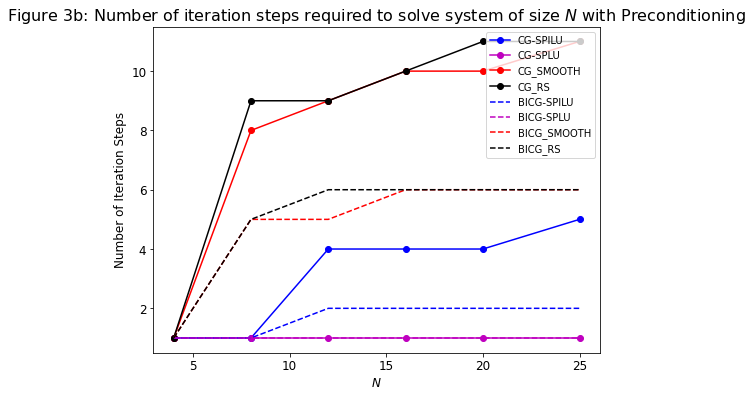

In [ ]:
N = np.array([4,8,12,16,20,25]) # These are what I interpret as small to medium values of N.

y1 = spilu_cg_iter = []
y2 = spilu_bicgstab_iter = []
y3 = splu_cg_iter = []
y4 = splu_bicgstab_iter = []
y5 = smooth_cg_iter = []
y6 = smooth_bicgstab_iter= []
y7 = ruge_cg_iter = []
y8 = ruge_bicgstab_iter = []

for n in N:
  
  y1.append(len(res_pc(n,cg,spilu))) 
  y2.append(len(res_pc(n,bicgstab,spilu)))
  y3.append(len(res_pc(n,cg,splu)))
  y4.append(len(res_pc(n,bicgstab,splu)))
  y5.append(len(res_pc(n,cg,smooth)))
  y6.append(len(res_pc(n,bicgstab,smooth)))
  y7.append(len(res_pc(n,cg,ruge)))
  y8.append(len(res_pc(n,bicgstab,ruge)))



  # Plotting for Relative Residuals
plt.figure(figsize = (8,6))
plt.xlabel('$N$', size = 12)
plt.ylabel('Number of Iteration Steps', size = 12)
plt.plot(N, y1, 'b-o')
plt.plot(N, y3, 'm-o')
plt.plot(N, y5, 'r-o')
plt.plot(N, y7, 'k-o')
plt.plot(N, y2, 'b--')
plt.plot(N, y4, 'm--')
plt.plot(N, y6, 'r--')
plt.plot(N, y8, 'k--')
plt.title('Figure 3b: Number of iteration steps required to solve system of size $N$ with Preconditioning', size = 16)
plt.legend(["CG-SPILU","CG-SPLU","CG_SMOOTH", "CG_RS",
          "BICG-SPILU","BICG-SPLU","BICG_SMOOTH", "BICG_RS"]) 
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

  


In [ ]:
def rt__cg(A,b,m):
  return cg(A,b,tol = 1e-14, M = m)

def rt__bgm(A,b,m):
  return bicgstab(A,b,tol = 1e-14, M = m)

def sparse_pc_time(operator,runs,N,m): # Pre-conditioned Solver Time 
  
  def op_time(operator,A,b,m,runs):
    assign = {'rt__cg': rt__cg,'rt__bgm': rt__bgm,'A': A ,'b': b}

    return timeit(lambda: operator(A,b,m), number = runs, globals = assign)
  
  output = []
  for n in N:

    A,b = fems(n)
    A1 = A.tocsc()
    pre_c1 = LinearOperator(matvec = spilu(A.tocsc(), fill_factor = 20, drop_rule = 'dynamic').solve,
        shape = A.shape, dtype = np.float64)
    
    pre_c2 = LinearOperator(matvec = splu(A1,permc_spec = 'NATURAL').solve,
        shape = A1.shape, dtype = np.float64)
    
    pre_c3 = smooth(A).aspreconditioner()

    pre_c4 = ruge(A).aspreconditioner()
    
    if m == spilu:
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
        output.append(op_time(operator,A,b,pre_c1,runs))
      if runs > 1:
        output.append(op_time(operator,A,b,pre_c1,runs)/runs)
    
    if m == splu:
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
        output.append(op_time(operator,A,b,pre_c2,runs))
      if runs > 1:
        output.append(op_time(operator,A,b,pre_c2,runs)/runs)
    
    if m == smooth:
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
        output.append(op_time(operator,A,b,pre_c3,runs))
      if runs > 1:
        output.append(op_time(operator,A,b,pre_c3,runs)/runs)
    
    if m == ruge:
      if runs <= 0:
        raise ValueError("Input needs to be a positive integer")
      if runs == 1:
        output.append(op_time(operator,A,b,pre_c1,runs))
      if runs > 1:
        output.append(op_time(operator,A,b,pre_c1,runs)/runs)
      
  return output




In [ ]:
N = np.array([4,5,10,15,20,25,30,35,40,45,50])

w1 = sparse_pc_time(rt__cg,10,N,spilu)
w2 = sparse_pc_time(rt__bgm,10,N,spilu)

w3 = sparse_pc_time(rt__cg,10,N,splu)
w4 = sparse_pc_time(rt__bgm,10,N,splu)

w5 = sparse_pc_time(rt__cg,10,N,smooth)
w6 = sparse_pc_time(rt__bgm,10,N,smooth)

w7 = sparse_pc_time(rt__cg,10,N,ruge)
w8 = sparse_pc_time(rt__bgm,10,N,ruge)


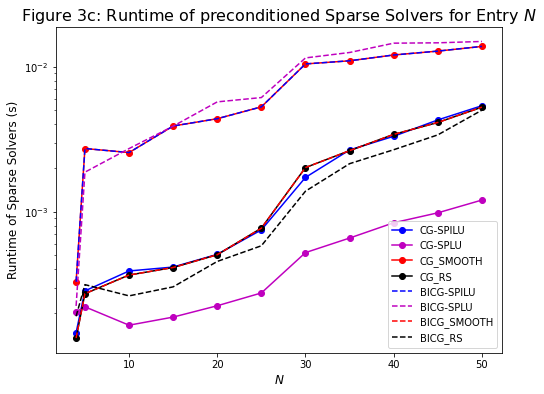

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(N,w1,"b-o")
plt.plot(N,w3,"m-o")
plt.plot(N,w5,"r-o")
plt.plot(N,w7,"k-o")
plt.plot(N,w5,"b--")
plt.plot(N,w6, "m--")
plt.plot(N,w7,"r--")
plt.plot(N,w8,"k--")

plt.xlabel("$N$", size = 12)
plt.ylabel("Runtime of Sparse Solvers (s)", size = 12)
plt.title("Figure 3c: Runtime of preconditioned Sparse Solvers for Entry $N$", size = 16)
plt.legend(["CG-SPILU","CG-SPLU","CG_SMOOTH", "CG_RS",
          "BICG-SPILU","BICG-SPLU","BICG_SMOOTH", "BICG_RS"]) 
plt.yscale("log")

My final choice for a preconditioned sparse solver is the ``cg`` solver with Super LU decomposition.

Figure 3a and 3b show that the Super LU pre-conditioner is superior to all the others for both ``cg`` and ``bicgstab``, only needing one iteration to produce an extremely small relative residual of magnitude $10^{-16}$. 

Figure 3c shows that the runtime for ``cg_splu`` is far better than ``bicgstab_splu`` as $N$ increases.Furthermore, the runtime very slowly increases as $N$ increases for ``cg_splu``. The combination of all three figures illustrate that the conjugate gradient method and splu preconditioner are the best at solving the finite element solution for Helmholtz wave problem. 



# Part 4: Increasing N to determine time order complexity and the rate of convergence.

Determining the error involves the use of ``numpy.lib.stride_tricks`` in order to achieve the $2 \times 2$ square required to work out the midpoint of the $i$-th column.

In [ ]:
Nx = range(10,140,10) # Very Large Matrices included
t1 = sparse_pc_time(rt__cg,10,Nx,splu)

Text(0.5, 1.0, 'Figure 4a: Matrix Vector product runtimes of size $N$')

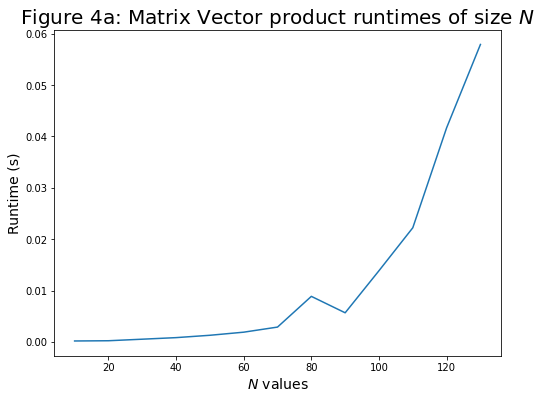

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(Nx,t1)
plt.xlabel("$N$",size = 14)
plt.ylabel("Runtime (s)", size = 14)
plt.title("Figure 4a: Matrix Vector product runtimes of size $N$",size = 20)


In [ ]:
def error(N):

  # Numerical Solution Preamble

  A,b = fems(N)
  h = 1/N
  A1 = A.tocsc()
  pre_c = LinearOperator(matvec = splu(A1,permc_spec = 'NATURAL').solve,
        shape = A1.shape, dtype = np.float64)
  
  # Numerical Solution
  x,_ = cg(A,b,tol = 1e-10,maxiter = 1000, M = pre_c)
  num = grid_outline(N) # Inserting Boundary Points
  num[1:N,1:N] += x.reshape(N-1,N-1)
  num = np.array(num)

  # Exact solution Preamble
  exact = np.zeros(shape = (N+1,N+1),  dtype = np.float64)
  n = np.arange(0,N+1,1)

  #Exact Solution
  for i in n:
    for j in n:
      x = j*h
      y = i*h
      exact[i,j] = np.sin(3*x + 4*y)
  
  # Constructing 'squares' for midpoint solutions, in a 2x2 form factor
  f1 = num.strides
  y1 = as_strided(num,shape = (N**2+(N),2,2),strides = (8,f1[0],f1[1]))

  f2 = exact.strides
  y2 = as_strided(exact,shape = (N**2+(N),2,2),strides = (8,f2[0],f2[1]))


  avg1 = []
  avg2 = []

  # Mean of all points in 2x2 grid
  for i in range(len(y1)):
    avg1.append(np.mean(y1[i]))
    avg2.append(np.mean(y2[i]))

  a1 = np.array(avg1)
  a2 = np.array(avg2)

  sums1 = []
  sums2 = []
  m = len(a1)
  
  for j in range(m):
    
      ''' This for loop removes boundary overlap points. Where the 2x2 grid 
    moves from the final point of one row are averaged to another 2 points in
    the start of the subsequent row. This leaves N**2 points m_i which is what
    is required '''

    # Simplest form of this condition is modulo. N + j*(N+1) is a boundary point
      if (j-N)%(N+1) != 0:
          sums1.append(a1[j])
          sums2.append(a2[j])
          
  sums1 = np.array(sums1)
  sums2 = np.array(sums2)

  errors = []
  for k in range(len(sums2)):

    # err = sum h**2( |u_exact(m_i) - u_h(m_i)| )
    diff = np.abs(np.abs(sums2[k])-np.abs(sums1[k]))
    errors.append((h**2)*diff)
    err = np.sum(errors)
  
  return err

In [ ]:
N1 = range(10,140,10)
err_vals = []
for i in N1:
  err_vals.append(error(i))


Text(0.5, 1.0, 'Figure 4b: Error in $u(x,y)_{\\mathrm{numerical}}$ and $u(x,y)_{\\mathrm{exact}}$ for Differing values of $N$')

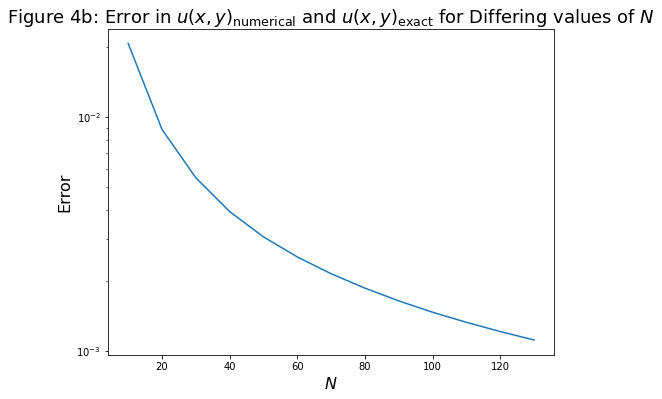

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(N1,err_vals)
plt.xlabel("$N$", size = 16)
plt.ylabel("Error", size = 16)
#plt.xscale("log")
plt.yscale("log")
plt.title("Figure 4b: Error in $u(x,y)_{\mathrm{numerical}}$ and $u(x,y)_{\mathrm{exact}}$ for Differing values of $N$", size = 18)

## Part 4 Comments

From Figure 4a, one can determine the time order complexity is $\mathcal{O}(N^2)$ for $N$ increasing from small to large values. This is due to the fact that the curve rises seemingly quadratically, at a much faster rate than $\mathcal(O)(N)$, which would be linearly increasing.

Figure 4b shows that the order of convergence of $\mathcal{O}(N^{-\alpha})$ corresponds to $0 < \alpha < 1$. This type of convergence appears to be **sublinear**. The graph is not decreasing linearly which means the order cannot be of order $\mathcal{O}(N^{-1})$. A suitable value for $\alpha$ would be close to 0.5 to show this sublinear convergence. 

$\alpha = 0.5$ is my final estimation for the order with the complexity being of order $\mathcal{O}(N^2)$

# Part 5: Parallelisating the Finite Element Solution

The process of parallelisation can be deployed in a bid to decrease the runtime in determining the finite element solution. 

The packages of ``multiprocessing`` and ``threading`` could be deployed in the function ``rt__cg(A,b,m)`` where I directly measure runtime of the function returning the CG solution to the matrix vector problem. Parallelisation could be achieved by decompartmentalising the matrix and vector into smaller components, utilising more CPU cores from the device's hardware to perform the matrix vector multipliation in parallel to each other. Solutions from these smaller components can be summed up and returned to retrieve the full finite element solution. The parallelisation process will not decrease runtime significantly for small values of $N$ and be virtually indistinguishable from a non-parallelised implementation. Values of $N$ which start to produce matrices and vectors such that $(N-1)^2$ is equal to over 1000 will see significant decreases in runtime such that the complexity of my solution can reach an order of $\mathcal{O}(N)$ instead of $\mathcal{O}(N^{2})$. such that in the case of $N = 130$, runtimes of less than $10^{-2} seconds can be achieved with relative ease.

The initial matrix and vector construction in ``fems(N)`` can also undergo parallelisation using the same libraries and process as stated above. When executing the entire programme, this can be useful as constructing very large sparse matrices do take a lot of time. $(N-1)^{2} \times (N-1)^2$ for values of $N = 100$ took a few minutes to form. However, the CG solution does not depend on the construction of the sparse matrix itself; this means parallelising the initial matrix and vectors would be futile to achieve faster runtimes for computing the finite element solution.


